**420-A52-SF - Algorithmes d'apprentissage supervisé - Hiver 2021 - Spécialisation technique en Intelligence Artificielle**<br/>
MIT License - Copyright (c) 2021 Mikaël Swawola
<br/>
![Travaux Pratiques - Comparaison kNN et régression logistique](static/11-tp-banner.png)
<br/>
**Objectif:** cette séance de travaux pratiques a pour objectif la comparaison des deux types de classificateurs vus en cours jusqu'à présent, à savoir la régression logistique et la classification kNN. Leur mise en oeuvre sera réalisée à l'aide de la librairie **scikit-learn** et la notion de **compromis biais-variance** sera étudiée. Le travail sera basé sur le jeu de données **Heart** entrevu précédemment

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## 0 - Chargement des bibliothèques

In [2]:
# Manipulation de données
import numpy as np
import pandas as pd

# Visualisation de données
import matplotlib.pyplot as plt
import seaborn as sns

# Helpers pour l'affichage
from helpers import plot_classifier

# Outils divers
from tqdm import tqdm
from collections import defaultdict

# Machine Learning
# Compléter l'importation des modules scikit-learn requis au fur et à mesure de l'atelier

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

In [3]:
# Configuration de la visualisation
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

## 1 - Lecture du jeu de données

<strong style="color: #006db4">Exercice 1-1: lire le fichier `Heart.csv`<strong/>

In [4]:
# Compléter le code ci-dessous ~ 1-2 lignes

cols = ['Age','Sex','ChestPain','RestBP','Chol','Fbs','RestECG','MaxHR','ExAng','Oldpeak','Slope','Ca','Thal','AHD']
HRT = pd.read_csv('../../data/Heart.csv', usecols=cols)

In [5]:
# On supprime tout de suite les données manquantes. Ceci sera vu plus en détail plus tard dans le cours
HRT = HRT.dropna()

<strong style="color: #006db4">Exercice 1-2: afficher les dix premières lignes de la trame de données HRT</strong>

In [6]:
# Compléter le code ci-dessous ~ 1 ligne

HRT.head(10)

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No
5,56,1,nontypical,120,236,0,0,178,0,0.8,1,0.0,normal,No
6,62,0,asymptomatic,140,268,0,2,160,0,3.6,3,2.0,normal,Yes
7,57,0,asymptomatic,120,354,0,0,163,1,0.6,1,0.0,normal,No
8,63,1,asymptomatic,130,254,0,2,147,0,1.4,2,1.0,reversable,Yes
9,53,1,asymptomatic,140,203,1,2,155,1,3.1,3,0.0,reversable,Yes


## 2 - Visualisation des données

La première étape avant toute étude d'apprentissage supervisé consiste à (essayer de) visualiser les données (voir cours de *Visualisation des données*). Cette étape est faite ici pour vous.

Remarque: l'affichage ci-dessous peut prendre quelques dizaines de secondes ...

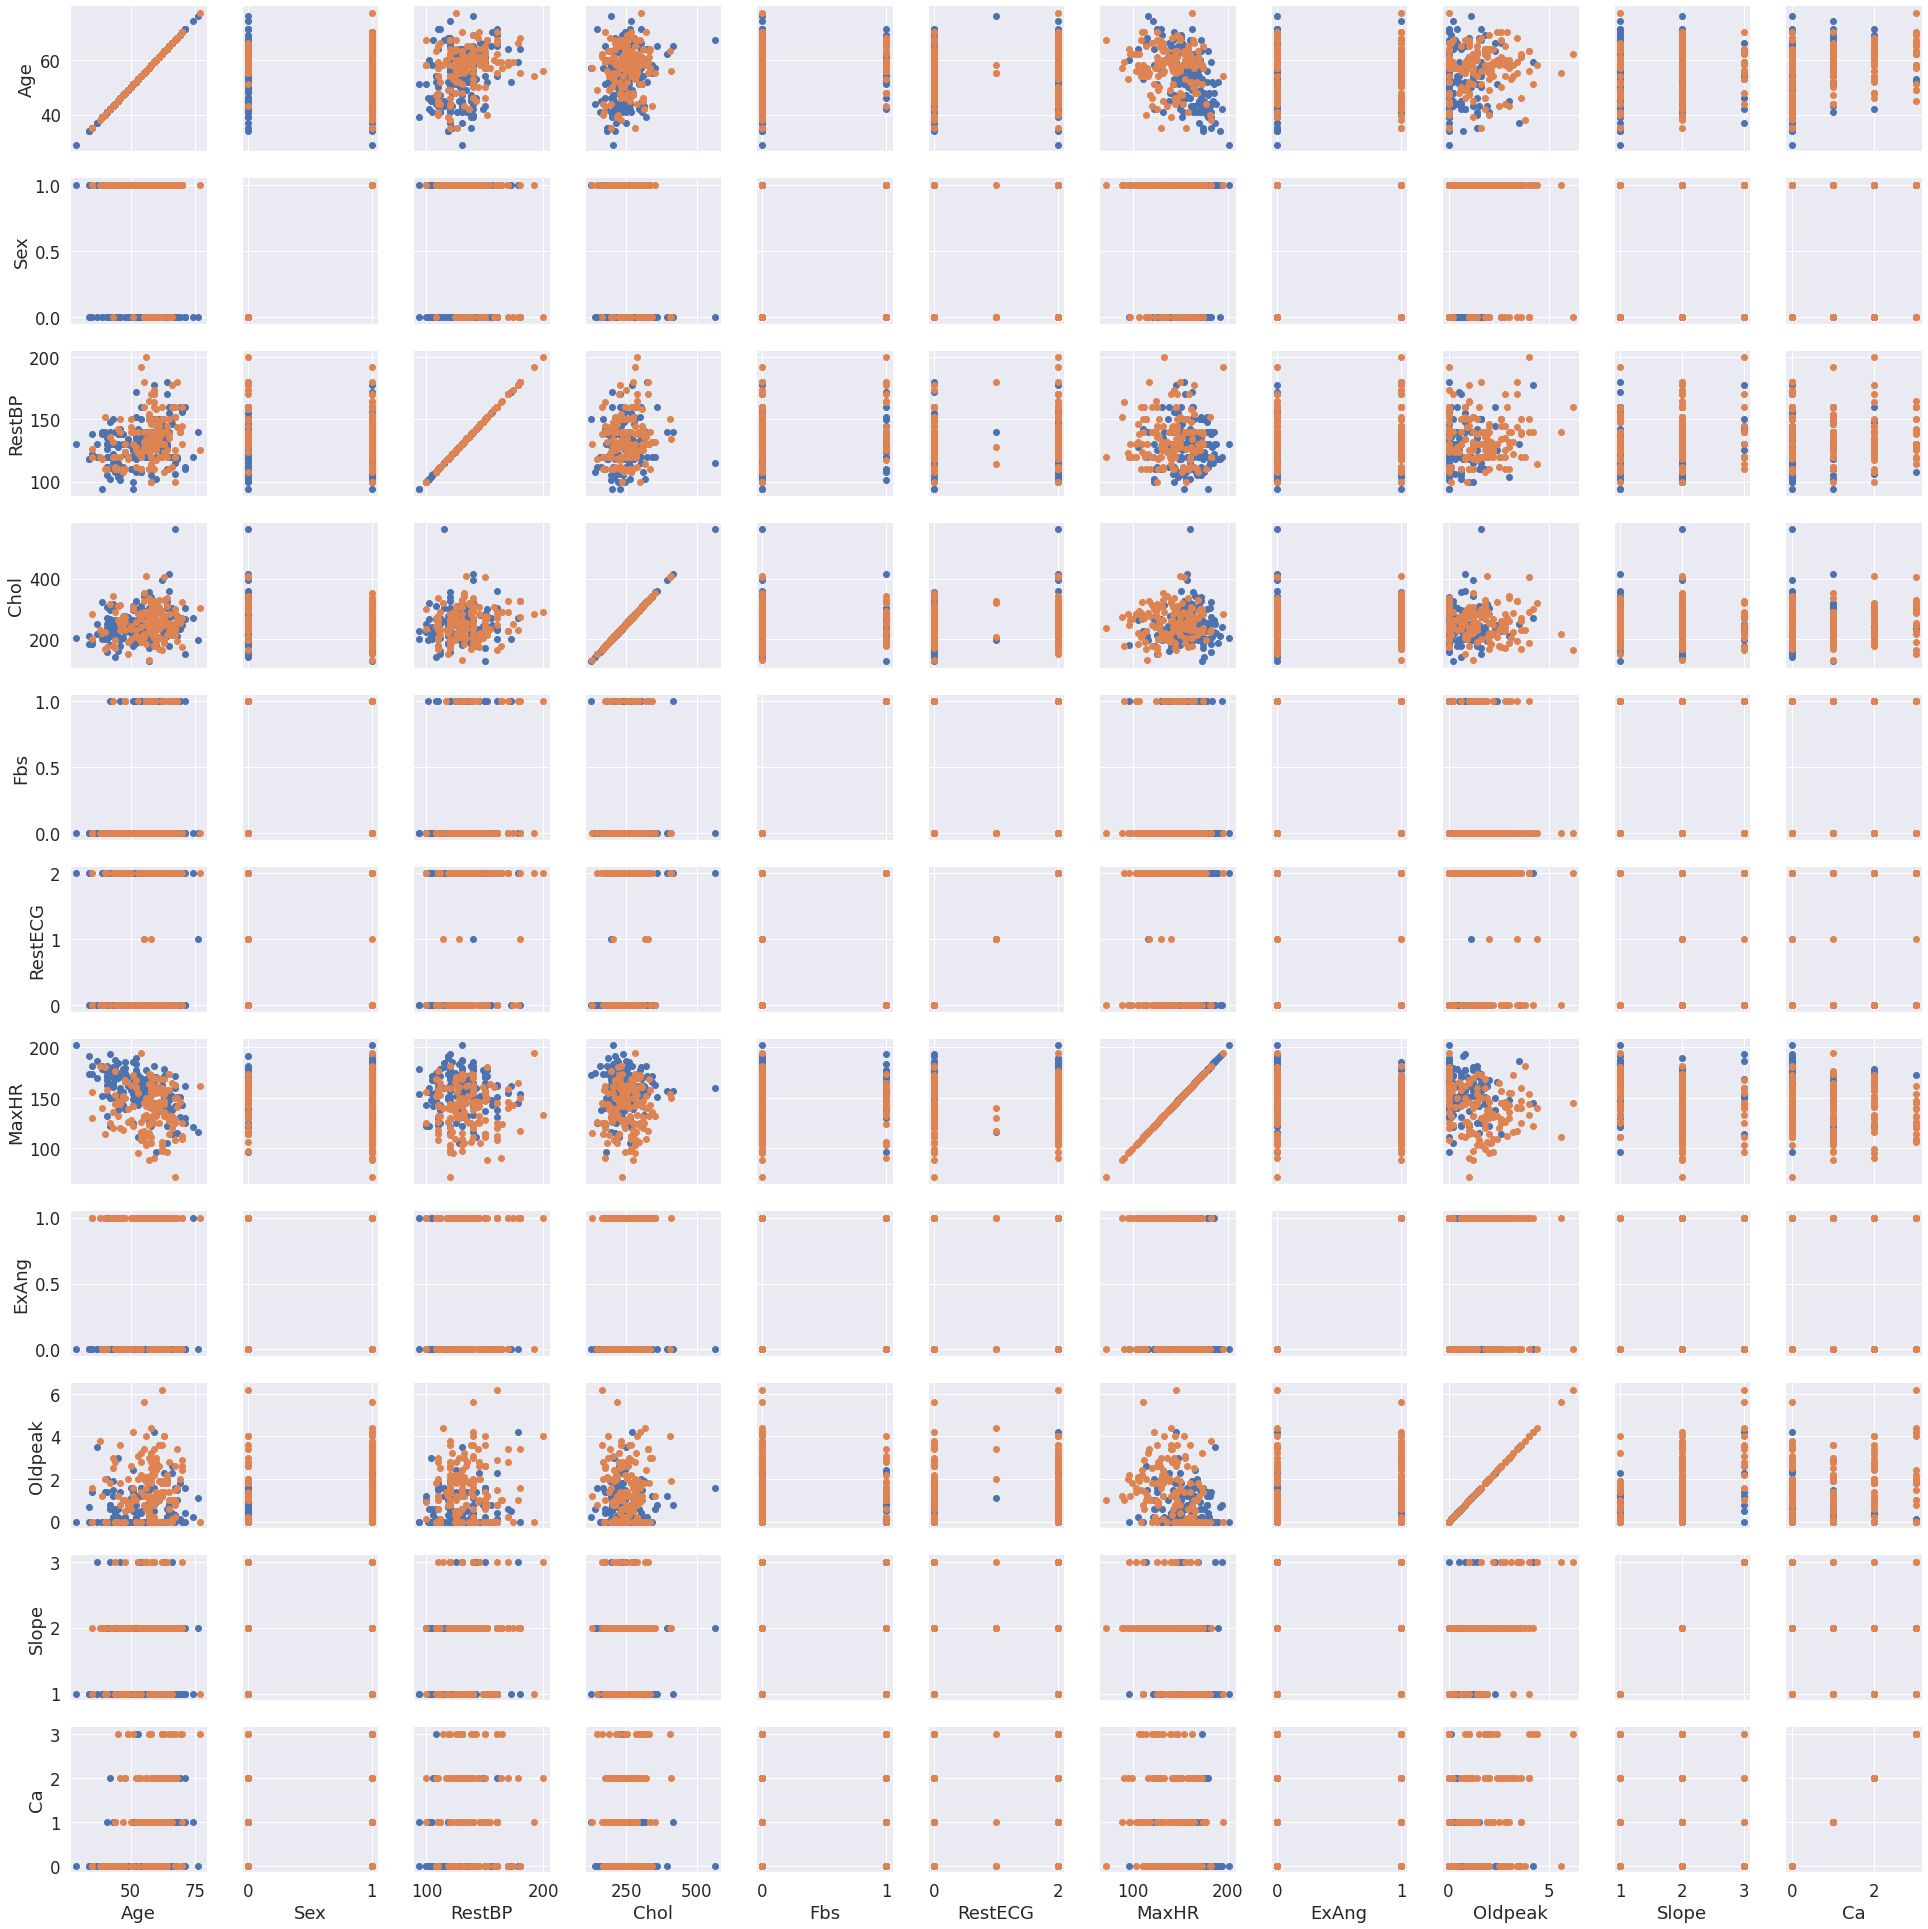

In [7]:
g = sns.PairGrid(HRT, hue="AHD")
g = g.map(plt.scatter)

Pour la suite de l'exercice, nous allons considérer uniquement les variables explicatives `Age` et `MaxHR`, ainsi que bien évidemment la variable réponse `AHD`

<strong style="color: #006db4">Exercice 2-1: créer une nouvelle trame de données ne contenant que les variables `Age`, `MaxHR` et `AHD`</strong>

In [8]:
# Compléter le code ci-dessous ~ 1 ligne

HRT2 = HRT[['Age','MaxHR','AHD']]

<strong style="color: #006db4">Exercice 2-2: afficher les dix premières lignes de la nouvelle trame de données `HRT2`</strong>

In [9]:
# Compléter le code ci-dessous ~ 1 ligne

HRT2.head(10)

,Age,MaxHR,AHD
0,63,150,No
1,67,108,Yes
2,67,129,Yes
3,37,187,No
4,41,172,No
5,56,178,No
6,62,160,Yes
7,57,163,No
8,63,147,Yes
9,53,155,Yes


## 3 - Affichage de HRT2

<AxesSubplot:xlabel='Age', ylabel='MaxHR'>

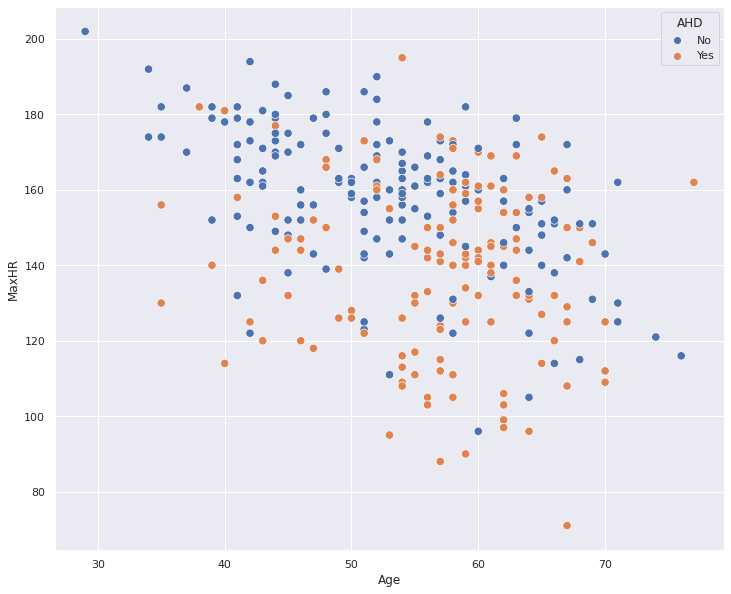

In [10]:
sns.set(style="darkgrid", rc={'figure.figsize':(12,10)})
sns.scatterplot(x='Age', y='MaxHR', hue="AHD", data=HRT2, s=70)

## 4 - Préparation des données en vue d'effectuer la validation des résultats des classificateurs

<strong style="color: #006db4">Exercice 4-1: extraire les variables explicatives dans un numpy array `X` et la variable réponse dans un vecteur `y`</strong>

In [11]:
# Compléter le code ci-dessous ~ 2 lignes

X = HRT2[['Age','MaxHR']].values
y = (HRT['AHD'] == "Yes").astype(int)

<strong style="color: #006db4">Exercice 4-2: à l'aide de scikit-learn, sépararer les données en jeu d'entraînement et jeu de test. La taille du jeu de test doit représenter 30% de la taille du jeu de données initial et l'état du générateur aléatoire sera fixé à 2020 afin de permettre la reproductibilité</strong>

In [12]:
# Compléter le code ci-dessous ~ 2 lignes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=2020)

In [13]:
print(f'X_train: {X_train.shape[0]} observations')
print(f'X_test: {X_test.shape[0]} observations')

X_train: 207 observations
X_test: 90 observations


## 5 - Régression logistique simple

<strong style="color: #006db4">Exercice 5-1: à l'aide de scikit-learn, effectuez la standardisation des données. Nommez les données standardisées `X1_scaled`</strong>

In [14]:
# Compléter le code ci-dessous ~ 3 lignes

scaler = StandardScaler()
scaler.fit(X_train)
X1_scaled = scaler.transform(X_train)

<strong style="color: #006db4">Exercice 5-2: à l'aide de scikit-learn, entraînez un modèle de régression logistique. Désactivez la régularisation.</strong>

<details>
<summary>
    <font size="3" color="darkgreen"><b>Cliquer ici pour obtenir un indice</b></font>
</summary>
<p>
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html"> class sklearn.linear_model.LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)</a>
</p>

In [15]:
# Compléter le code ci-dessous ~ 1 ligne

clf1 = LogisticRegression(penalty="none", fit_intercept=True).fit(X1_scaled, y_train)

#### Affichage des résultats

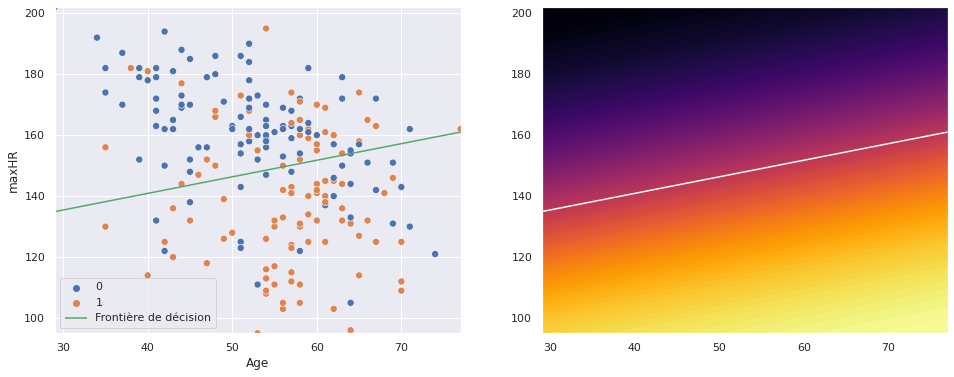

In [16]:
sns.set(rc={'figure.figsize':(16,6)})
plot_classifier(X_train, y_train, clf1, scaler, order=1, xlabel="Age", ylabel="maxHR")

<strong style="color: #006db4">Exercice 5-3: évaluez les performances sur le jeu d'entraînement. De quelle métrique s'agit-il ?</strong>

In [17]:
# Compléter le code ci-dessous ~ 1 ligne

clf1.score(X1_scaled, y_train)

0.6956521739130435

<strong style="color: #006db4">Exercice 5-4: évaluez maintenant les performances sur le jeu de test</strong>

In [18]:
# Compléter le code ci-dessous ~ 2-3 lignes

X1_test_scaled = scaler.transform(X_test)
clf1.score(X1_test_scaled, y_test)

0.6666666666666666

## 6 - Régression logistique avec variables d'interaction et variables polynomiales d'ordre 2

<strong style="color: #006db4">Exercice 6-1: à l'aide de scikit-learn, construisez la matrice des prédicteurs `X2` en incluant les variables d'interactions et les variables polynomiales d'ordre 2. N'incluez pas le biais (ou intercept)</strong>

<details>
<summary>
    <font size="3" color="darkgreen"><b>Cliquer ici pour obtenir un indice</b></font>
</summary>
<p>
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html"> class class sklearn.preprocessing.PolynomialFeatures(degree=2, *, interaction_only=False, include_bias=True, order='C')</a>
</p>

In [19]:
# Compléter le code ci-dessous ~ 1-2 lignes

poly2 = PolynomialFeatures(2, include_bias=False)
X2 = poly2.fit_transform(X_train)

<strong style="color: #006db4">Exercice 6-2: à l'aide de scikit-learn, standardisez la matrice des prédicteurs</strong>

In [20]:
# Compléter le code ci-dessous ~ 1-3 lignes

scaler = StandardScaler()
scaler.fit(X2)
X2_scaled = scaler.transform(X2)

<strong style="color: #006db4">Exercice 6-3:  l'aide de scikit-learn, entraînez un modèle de régression logistique. Comme précédemment, désactivez la régularisation.</strong>

In [21]:
# Compléter le code ci-dessous ~ 1 ligne

clf2 = LogisticRegression(penalty="none", fit_intercept=True).fit(X2_scaled, y_train)

#### Affichage des résultats

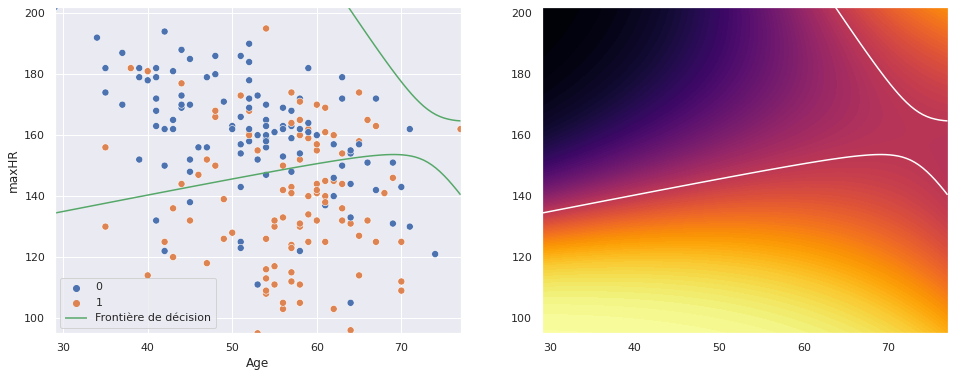

In [22]:
sns.set(rc={'figure.figsize':(16,6)})
plot_classifier(X_train, y_train, clf2, scaler, order=2, xlabel="Age", ylabel="maxHR")

<strong style="color: #006db4">Exercice 6-4: évaluez les performances sur le jeu d'entraînement</strong>

In [23]:
# Compléter le code ci-dessous ~ 1 ligne

clf2.score(X2_scaled, y_train)

0.6956521739130435

<strong style="color: #006db4">Exercice 6-5: évaluez maintenant les performances sur le jeu de test</strong>

In [24]:
# Compléter le code ci-dessous ~ 2-3 lignes

X2_test = poly2.fit_transform(X_test)
X2_test_scaled = scaler.transform(X2_test)
clf2.score(X2_test_scaled,y_test)

0.6444444444444445

## 7 - Régression logistique avec variables d'interaction et variables polynomiales d'ordre 3

<strong style="color: #006db4">Exercice 7-1: construisez la matrice des prédicteurs `X3` incluant les variables d'interactions et les variables polynomiales d'ordre 3. Ne pas inclure le biais (ou intercept)</strong>

In [25]:
# Compléter le code ci-dessous ~ 1-2 lignes

poly3 = PolynomialFeatures(3, include_bias=False)
X3 = poly3.fit_transform(X_train)

<strong style="color: #006db4">Exercice 7-2: standardisez la matrice des prédicteurs</strong>

In [26]:
# Compléter le code ci-dessous ~ 1-3 lignes

scaler = StandardScaler()
scaler.fit(X3)
X3_scaled = scaler.transform(X3)

<strong style="color: #006db4">Exercice 7-3: entraînez un modèle de régression logistique. Comme précédemment, désactivez la régularisation. Quel paramètre supplémentaire devez-vous changer ?</strong>

In [27]:
# Compléter le code ci-dessous ~ 1 ligne

clf3 = LogisticRegression(penalty="none", fit_intercept=True, max_iter=1000).fit(X3_scaled, y_train)

#### Affichage des résultats

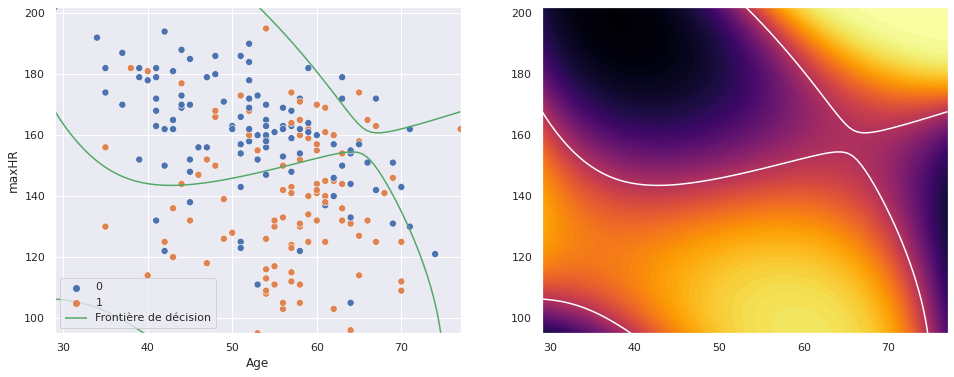

In [28]:
sns.set(rc={'figure.figsize':(16,6)})
plot_classifier(X_train, y_train, clf3, scaler, order=3, xlabel="Age", ylabel="maxHR")

<strong style="color: #006db4">Exercice 7-4: évaluez les performances sur le jeu d'entraînement</strong>

In [29]:
# Compléter le code ci-dessous ~ 1 ligne

clf3.score(X3_scaled, y_train)

0.7101449275362319

<strong style="color: #006db4">Exercice 7-5: évaluez maintenant les performances sur le jeu de test</strong>

In [30]:
# Compléter le code ci-dessous ~ 2-3 lignes

X3_test = poly3.fit_transform(X_test)
X3_test_scaled = scaler.transform(X3_test)
clf3.score(X3_test_scaled, y_test)

0.6666666666666666

## 8 - Régression logistique avec variables d'interaction et variables polynomiales d'ordre 6

<strong style="color: #006db4">Exercice 8-1: construisez la matrice des prédicteurs `X6` incluant les variables d'interactions et les variables polynomiales d'ordre 6. Ne pas inclure le biais (ou intercept)</strong>

In [31]:
# Compléter le code ci-dessous ~ 1-2 lignes

poly6 = PolynomialFeatures(6, include_bias=False)
X6 = poly6.fit_transform(X_train)

<strong style="color: #006db4">Exercice 8-2: standardisez la matrice des prédicteurs</strong>

In [32]:
# Compléter le code ci-dessous ~ 1-3 lignes

scaler = StandardScaler()
scaler.fit(X6)
X6_scaled = scaler.transform(X6)

<strong style="color: #006db4">Exercice 8-3: entraînez un modèle de régression logistique. Comme précédemment, désactivez la régularisation.</strong>

In [33]:
# Compléter le code ci-dessous ~ 1 ligne

clf6 = LogisticRegression(penalty="none", fit_intercept=True, max_iter=5000).fit(X6_scaled, y_train)

#### Affichage des résultats

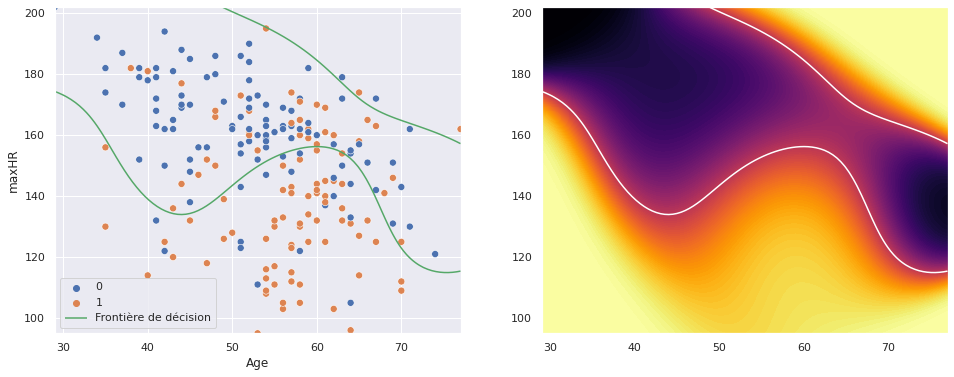

In [34]:
sns.set(rc={'figure.figsize':(16,6)})
plot_classifier(X_train, y_train, clf6, scaler, order=6, xlabel="Age", ylabel="maxHR")

<strong style="color: #006db4">Exercice 8-4: évaluez les performances sur le jeu d'entraînement</strong>

In [35]:
# Compléter le code ci-dessous ~ 1 ligne

clf6.score(X6_scaled, y_train)

0.7294685990338164

<strong style="color: #006db4">Exercice 8-5: évaluez maintenant les performances sur le jeu de test</strong>

In [36]:
# Compléter le code ci-dessous ~ 2-3 lignes

X6_test = poly6.fit_transform(X_test)
X6_test_scaled = scaler.transform(X6_test)
clf6.score(X6_test_scaled, y_test)

0.7222222222222222

## 9 - Classification kNN

<strong style="color: #006db4">Exercice 9-1: à l'aide de scikit-learn, entraînez un modèle de classification KNN. Choisissez K=22</strong>

<details>
<summary>
    <font size="3" color="darkgreen"><b>Cliquer ici pour obtenir un indice</b></font>
</summary>
<p>
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html">class sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None, **kwargs)</a>
</p>

In [37]:
# Compléter le code ci-dessous ~ 2 lignes

neigh = KNeighborsClassifier(n_neighbors=22)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=22)

#### Affichage des résultats

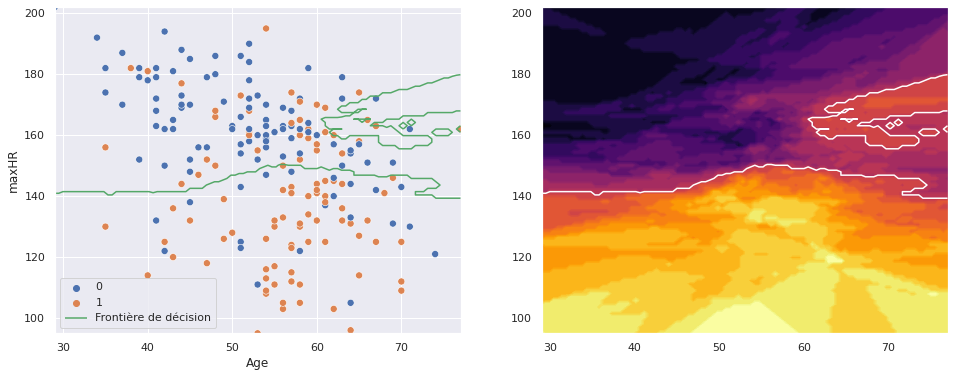

In [38]:
sns.set(rc={'figure.figsize':(16,6)})
plot_classifier(X_train, y_train, neigh, scaler=None, xlabel="Age", ylabel="maxHR")

<strong style="color: #006db4">Exercice 9-2: évaluez les performances sur le jeu d'entraînement</strong>

In [39]:
# Compléter le code ci-dessous ~ 1 ligne

neigh.score(X_train, y_train)

0.7198067632850241

<strong style="color: #006db4">Exercice 9-3: évaluez maintenant les performances sur le jeu de test</strong>

In [40]:
# Compléter le code ci-dessous ~ 1 ligne

neigh.score(X_test,y_test)

0.6666666666666666

<strong style="color: #006db4">Exercice 9-4: Essayez d'autres valeurs de K. Quelle est selon la valeur de K offrant un bon compromis biais-variance?</strong>

K = 9 semble offrir un bon compromis biais-variance

## 10 - Recherche des meilleurs hyperparamètres

### 10 - 1 - Préparation des jeux de données

Nous allons maintenant considérer l'ensemble des variables explicatives du jeu de données **Heart**

<strong style="color: #006db4">Exercice 10-1-1: Encoder les variables explicatives catégorielles. Indice: utilisez pandas ;-)</strong>

In [41]:
# Compléter le code ci-dessous ~ 2-3 lignes

HRT_onehot = pd.get_dummies(HRT, columns=['ChestPain','Thal'], prefix = ['cp','thal'], drop_first=True)
X = HRT_onehot.drop(['AHD'], axis=1)
y = (HRT['AHD'] == "Yes").astype(int)

<strong style="color: #006db4">Exercice 10-1-2: Quel est le nombre de variables explicatives ?</strong>

In [42]:
# Compléter le code ci-dessous ~ 1 ligne

X.shape[1]

16

<strong style="color: #006db4">Exercice 10-1-3: à l'aide de scikit-learn, sépararer les données en jeu d'entraînement et jeu de test. La taille du jeu de test doit représenter 30% de la taille du jeu de données et l'état du générateur aléatoire sera fixé à 2020 afin de permettre la reproductibilité</strong>

In [43]:
# Compléter le code ci-dessous ~ 1 ligne

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=2020)

### 10 - 2  - Régression logistique

<strong style="color: #006db4">Exercice 10-2: réalisez plusieurs fois une régression logistique polynomiale (cette fois-ci SANS variables d'interaction) en faisant varier l'ordre `n` de 1 à 15. Vous pouvez utiliser la fonction `polynomial` ci-dessous. Enregistrez les scores sur les jeux d'entraînement et de test pour chaque valeur de `n` dans le dictionnaire `history`</strong>

In [55]:
def polynomial(X, degree=2):
    vec = [np.ones((X.shape[0],1))]
    for d in range(1,degree+1):
        temp = np.array((X**d))
        vec.append(temp)
    return np.hstack(vec)

In [57]:
history = defaultdict(list)
for n in tqdm(range(1,15)):
    # Compléter le code ci-dessous ~ quelques lignes ...
    
    # variables polynomiales
    X_temp = polynomial(X_train, degree=n)[:,1:]
    
    # Standardisation
    scaler = StandardScaler()
    scaler.fit(X_temp)
    X_scaled = scaler.transform(X_temp)
    
    # Régression logistique
    clf = LogisticRegression(penalty="none", solver="sag", fit_intercept=True, max_iter=200000).fit(X_scaled, y_train)
    
    # Performances
    Xn_test =  polynomial(X_test, degree=n)[:,1:]
    X_test_scaled = scaler.transform(Xn_test)
    history['train'].append(clf.score(X_scaled, y_train))
    history['test'].append(clf.score(X_test_scaled, y_test))

100%|██████████| 14/14 [00:27<00:00,  1.94s/it]


#### Affichage de la courbe de validation

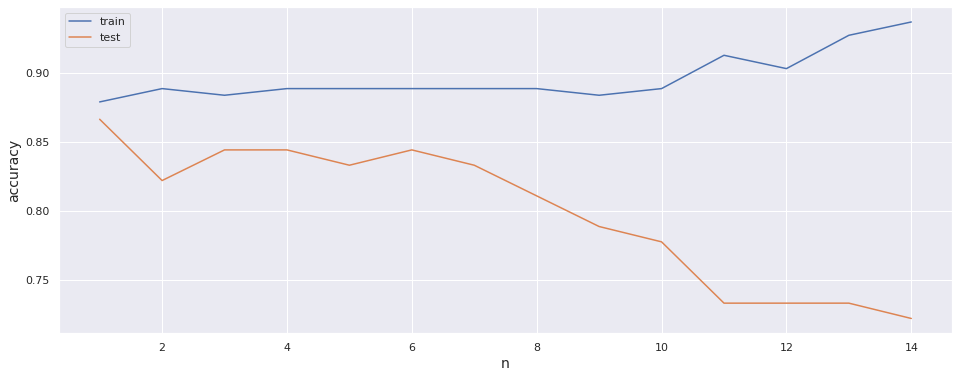

In [58]:
f, ax = plt.subplots(1,1)
ax.plot(range(1,15), history['train'], label="train")
ax.plot(range(1,15), history['test'], label="test")
ax.set_xlabel('n', fontsize=14)
ax.set_ylabel('accuracy', fontsize=14)
ax.legend()

### 10 - 3  - Classification kNN

<strong style="color: #006db4">Exercice 10-3: réalisez plusieurs fois une classification kNN en faisant varier le nombre de voisins `k` de 1 à 200. Enregistrez les scores sur les jeux d'entraînement et de test pour chaque valeur de `n` dans le dictionnaire `history`</strong>

In [59]:
history = defaultdict(list)
for k in tqdm(range(1,200)):
    # Compléter le code ci-dessous ~ quelques lignes ...
    
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    history['train'].append(neigh.score(X_train, y_train))
    history['test'].append(neigh.score(X_test, y_test))

100%|██████████| 199/199 [00:08<00:00, 22.29it/s]


#### Affichage de la courbe de validation

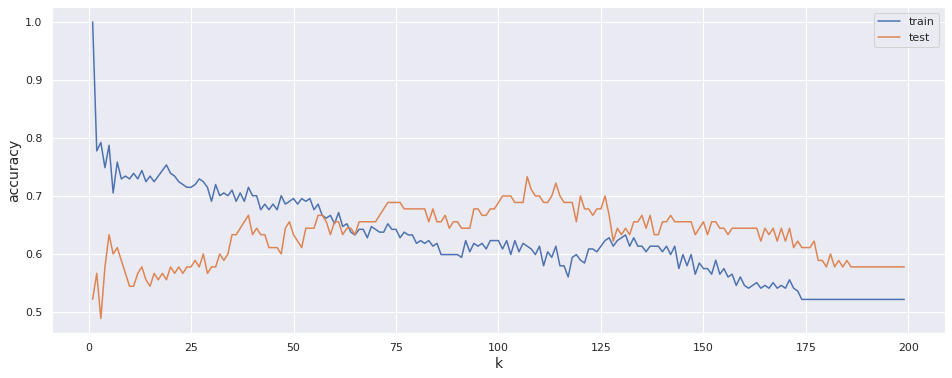

In [60]:
f, ax = plt.subplots(1,1)
ax.plot(range(1,200),history['train'], label="train")
ax.plot(range(1,200), history['test'], label="test")
ax.set_xlabel('k', fontsize=14)
ax.set_ylabel('accuracy', fontsize=14)
ax.legend()

### 11 - 3 - Choix du modèle

<strong style="color: #006db4">Exercice 11-3: Quel modèle choisissez-vous ? Quels sont les valeurs des hyperparamètres ?</strong>

### Fin du TP